In [1]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import pickle

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)


x_whole_obs = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole_obs = pd.concat([y_train_obs_combined, y_val_obs_combined])

x_whole_est = pd.concat([X_train_est_combined, X_val_est_combined])
y_whole_est = pd.concat([y_train_est_combined, y_val_est_combined])

x_whole_est.head(10)

After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 61), X_test_estimated_b_processed.shape = (720, 61), X_test_estimated_c_processed.shape = (720, 61)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,residual_radiation,cloud_ratio,diffuse_cloud_conditional_interaction,cloud_cover_over_30%,sun_addition,direct_rad_cloud_interaction,modified_solar_elevation_squared,is_freezing,is_snow,is_rain
30068,6.900,1.26900,1.654025e+03,0.000000,2871.250000,0.0,278.450012,0.000000,3816.800049,0.000000,0.000000,27.200001,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1020.875000,0.0,0.0,1008.049988,1014.250000,0.000000,0.0,82.650002,1020.450012,0.0,0.0,0.0,239.816254,0.000,280.524994,35.200001,39068.875000,1.100,0.550,0.950,0.0,1,0,0,-0.737943,0.674863,-0.707107,-0.707107,0.000000,0.000000,0.000000,1,0.000000,0.772727,0.0,0,0.000000,0.000000,0.000000,0,0,0
32683,3.775,1.27950,7.385284e+05,163.850006,681.250000,0.0,269.825012,83.225006,318197.500000,42.950001,274824.093750,79.074997,0.000,0.000,0.000,0.00,0.000,1.00,0.00,1014.349976,0.0,0.0,1001.049988,1007.325012,0.000000,0.0,65.500000,1013.599976,0.0,0.0,0.0,224.040497,0.000,273.875000,79.074997,28104.949219,8.000,6.000,-5.300,0.0,1,0,0,0.867099,0.498137,-0.500000,-0.866025,3574.514160,0.213666,0.372124,1,37.675003,1.000000,0.0,1,126.175003,898.728882,0.462240,0,0,0
31298,2.500,1.30150,0.000000e+00,0.000000,1939.224976,0.0,264.625000,0.000000,0.000000,0.000000,0.000000,100.000000,0.150,0.150,0.150,0.15,0.150,0.00,1.00,1010.549988,0.0,0.0,997.349976,1003.650024,0.000000,0.0,59.200001,1010.049988,0.0,0.0,0.3,320.041260,0.100,269.849976,100.000000,11110.724609,5.600,-5.575,0.600,0.0,1,0,0,0.051584,0.998669,-0.707107,0.707107,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,1,0.000000,0.000000,0.000000,1,1,0
96801,4.250,1.26900,0.000000e+00,0.000000,389.500000,0.0,271.549988,0.000000,0.000000,0.000000,0.000000,74.199997,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1013.599976,0.0,0.0,998.099976,1004.275024,0.000000,0.0,62.700001,1010.474976,0.0,0.0,0.0,264.199005,0.000,277.500000,87.925003,57794.398438,4.900,-0.975,4.800,0.0,0,0,1,-0.597829,0.801624,-0.965926,-0.258819,0.000000,0.000000,0.000000,1,0.000000,0.843901,0.0,1,0.000000,0.000000,0.000000,0,0,0
65078,4.575,1.28800,0.000000e+00,0.000000,9417.000000,0.0,272.424988,0.000000,0.000000,0.000000,0.000000,47.924999,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1020.700012,0.0,0.0,1007.400024,1013.700012,0.000000,0.0,66.500000,1020.000000,0.0,0.0,0.0,66.585251,0.000,276.799988,95.850006,51880.398438,3.000,-0.100,2.975,0.0,0,1,0,0.608121,0.793844,0.707107,0.707107,0.000000,0.000000,0.000000,1,0.000000,0.500000,0.0,1,0.000000,0.000000,0.000000,0,0,0
65140,3.350,1.27825,0.000000e+00,0.000000,1488.900024,0.0,268.325012,0.000000,0.000000,0.000000,0.000000,100.000000,6.575,1.725,9.075,4.45,4.875,0.00,1.00,998.924988,0.1,3.0,985.650024,991.849976,0.000000,0.0,76.000000,998.150024,0.0,0.0,1.3,261.451508,0.075,271.799988,100.000000,2295.149902,1.925,-1.500,1.150,0.0,0,1,0,0.635068,0.772456,-0.965926,-0.258819,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,1,0.000000,0.000000,0.000000,1,1,1
97694,4.625,1.27125,0.000000e+00,0.000000,4061.900146,-1.0,272.475006,0.000000,0.000000,0.000000,0.000000,61.525002,0.000,0.000,0.000,0.00,0.000,0.00,1.00,1002.299988,0.0,0.0,986.950012,993.099976,27.575001,0.0,83.199997,

In [3]:
x_whole["time_since_prediction"].describe()

count    87876.000000
mean         0.123265
std          0.328743
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: time_since_prediction, dtype: float64

In [4]:
x_whole["pv_measurement"] = y_whole
df_shuffled = x_whole.sample(frac=1, random_state=42).reset_index(drop=True)
x_whole_a = df_shuffled[df_shuffled['location_a'] == 1]
x_whole_b = df_shuffled[df_shuffled['location_b'] == 1]
x_whole_c = df_shuffled[df_shuffled['location_c'] == 1]

y_whole_a = x_whole_a["pv_measurement"]
x_whole_a = x_whole_a.drop("pv_measurement", axis = 1)
x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

y_whole_b = x_whole_b["pv_measurement"]
x_whole_b = x_whole_b.drop("pv_measurement", axis = 1)
x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

y_whole_c = x_whole_c["pv_measurement"]
x_whole_c = x_whole_c.drop("pv_measurement", axis = 1)
x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)
cat_features = ["time_since_prediction"]

In [5]:
best_model_a = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function="MAE",
    verbose = 100
)
best_model_a.fit(x_whole_a, y_whole_a)

0:	learn: 615.2289223	total: 91.7ms	remaining: 1m 31s
100:	learn: 201.4072982	total: 2.13s	remaining: 18.9s
200:	learn: 186.0497580	total: 3.97s	remaining: 15.8s
300:	learn: 181.1303390	total: 5.79s	remaining: 13.4s
400:	learn: 177.2485579	total: 7.54s	remaining: 11.3s
500:	learn: 172.6623044	total: 9.4s	remaining: 9.36s
600:	learn: 163.7204714	total: 11.3s	remaining: 7.52s
700:	learn: 154.4498268	total: 13.3s	remaining: 5.66s
800:	learn: 146.6204772	total: 15.2s	remaining: 3.77s
900:	learn: 139.9470005	total: 16.9s	remaining: 1.86s
999:	learn: 134.5556506	total: 18.7s	remaining: 0us


In [6]:
x_whole_a["time_since_prediction"].describe()

count    34046.000000
mean         0.129061
std          0.335272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: time_since_prediction, dtype: float64

                                  Feature    Importance
0                absolute_humidity_2m:gm3  1.043385e+00
1                     air_density_2m:kgm3  9.419058e-01
2                   clear_sky_energy_1h:J  3.456527e+00
3                         clear_sky_rad:W  5.488244e+00
4                        cloud_base_agl:m  1.652099e+00
5                         dew_or_rime:idx  9.477881e-04
6                          dew_point_2m:K  9.605845e-01
7                           diffuse_rad:W  1.012781e+00
8                        diffuse_rad_1h:J  1.598362e+00
9                            direct_rad:W  2.769480e+00
10                        direct_rad_1h:J  4.093084e+00
11                effective_cloud_cover:p  2.927910e+00
12                      fresh_snow_12h:cm  1.107744e-01
13                       fresh_snow_1h:cm  6.839708e-04
14                      fresh_snow_24h:cm  1.554163e-01
15                       fresh_snow_3h:cm  5.249190e-03
16                       fresh_snow_6h:cm  8.414

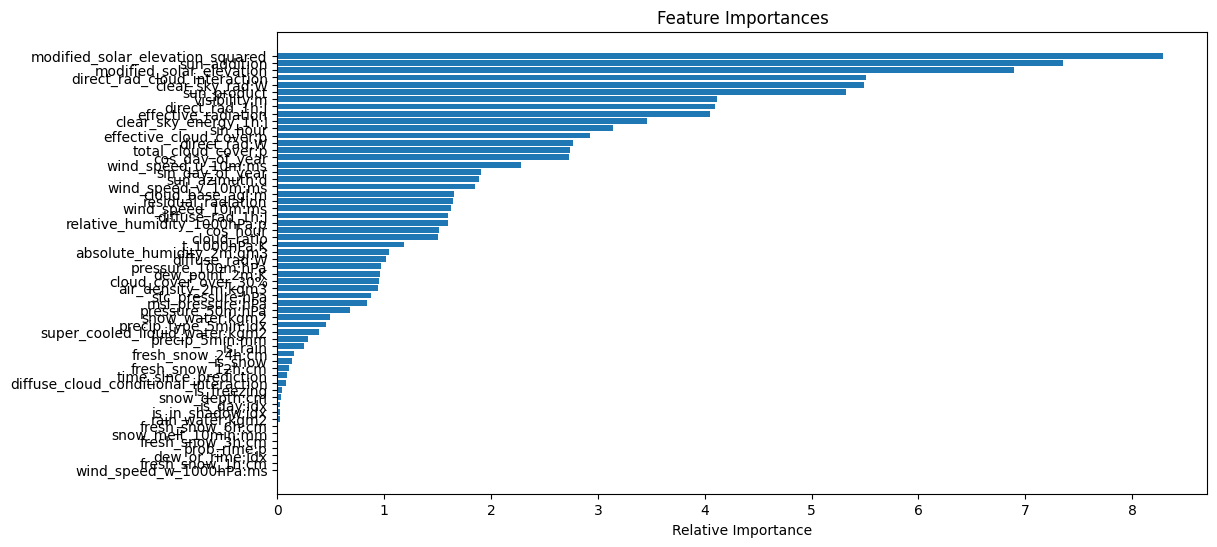

In [7]:
feature_importances = best_model_a.get_feature_importance()

# Get feature names
feature_names = x_whole_a.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# Display the feature importances
print(feature_importance_df)
# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [8]:
best_model_b = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function="MAE",
    verbose = 100
)
best_model_b.fit(x_whole_b, y_whole_b)

0:	learn: 94.2791670	total: 31.9ms	remaining: 31.9s
100:	learn: 25.1394341	total: 1.9s	remaining: 16.9s
200:	learn: 21.7299397	total: 3.67s	remaining: 14.6s
300:	learn: 20.2992389	total: 5.46s	remaining: 12.7s
400:	learn: 19.0627633	total: 7.24s	remaining: 10.8s
500:	learn: 17.9527669	total: 9.03s	remaining: 9s
600:	learn: 17.1682651	total: 10.8s	remaining: 7.19s
700:	learn: 16.6932226	total: 12.7s	remaining: 5.4s
800:	learn: 15.8845163	total: 14.5s	remaining: 3.6s
900:	learn: 15.3506132	total: 16.3s	remaining: 1.79s
999:	learn: 14.9515366	total: 18.2s	remaining: 0us


                                  Feature  Importance
3                         clear_sky_rad:W    8.342514
52                           sun_addition    6.464792
53           direct_rad_cloud_interaction    5.788001
45               modified_solar_elevation    5.689751
2                   clear_sky_energy_1h:J    5.195506
54       modified_solar_elevation_squared    5.138716
9                            direct_rad:W    4.602944
10                        direct_rad_1h:J    3.738508
7                           diffuse_rad:W    2.992828
4                        cloud_base_agl:m    2.897422
42                               sin_hour    2.870614
48                     residual_radiation    2.752399
44                            sun_product    2.721378
40                        sin_day_of_year    2.694257
46                    effective_radiation    2.662344
41                        cos_day_of_year    2.661469
33                            t_1000hPa:K    2.352271
11                effective_

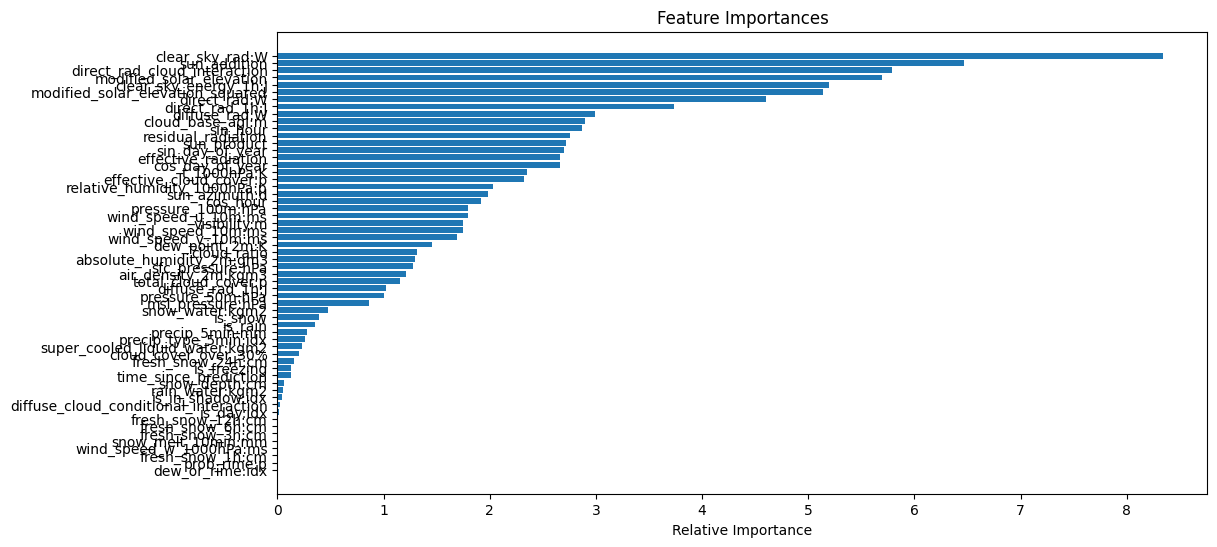

In [9]:
feature_importances = best_model_b.get_feature_importance()

# Get feature names
feature_names = x_whole_b.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [10]:
best_model_c = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function = "MAE",
    verbose = 100
)
best_model_c.fit(x_whole_c, y_whole_c)

0:	learn: 78.8208115	total: 23.7ms	remaining: 23.7s
100:	learn: 21.4396391	total: 1.81s	remaining: 16.1s
200:	learn: 18.5151414	total: 3.54s	remaining: 14.1s
300:	learn: 17.0987782	total: 5.33s	remaining: 12.4s
400:	learn: 16.0406782	total: 7.1s	remaining: 10.6s
500:	learn: 15.0533016	total: 8.85s	remaining: 8.82s
600:	learn: 14.2314945	total: 10.6s	remaining: 7.03s
700:	learn: 13.6329705	total: 12.3s	remaining: 5.25s
800:	learn: 13.1507093	total: 14.1s	remaining: 3.5s
900:	learn: 12.7614489	total: 15.8s	remaining: 1.73s
999:	learn: 12.4840959	total: 17.5s	remaining: 0us


                                  Feature  Importance
45               modified_solar_elevation    9.167129
9                            direct_rad:W    7.843248
3                         clear_sky_rad:W    7.642986
10                        direct_rad_1h:J    5.803242
2                   clear_sky_energy_1h:J    5.304783
44                            sun_product    4.286788
54       modified_solar_elevation_squared    4.247043
53           direct_rad_cloud_interaction    3.947823
52                           sun_addition    3.794217
33                            t_1000hPa:K    3.571950
26            relative_humidity_1000hPa:p    3.160275
46                    effective_radiation    2.515356
48                     residual_radiation    2.487088
40                        sin_day_of_year    2.237831
41                        cos_day_of_year    2.114798
38                    wind_speed_v_10m:ms    2.076690
37                    wind_speed_u_10m:ms    2.048721
11                effective_

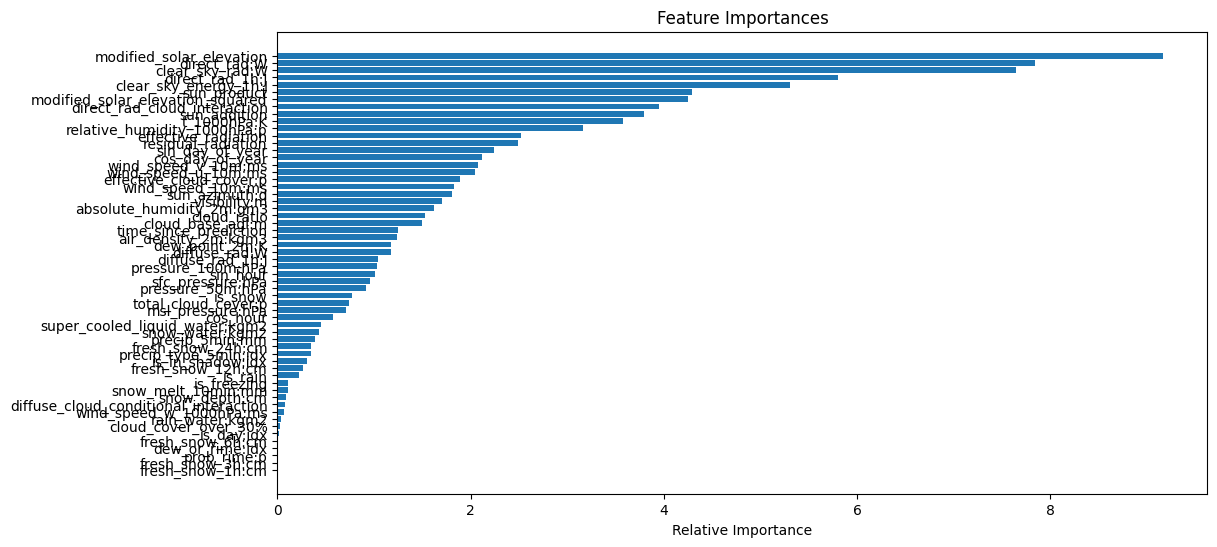

In [11]:
feature_importances = best_model_c.get_feature_importance()

# Get feature names
feature_names = x_whole_c.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

In [12]:
x_whole_a = x_test_whole[x_test_whole['location_a'] == 1]
x_whole_b = x_test_whole[x_test_whole['location_b'] == 1]
x_whole_c = x_test_whole[x_test_whole['location_c'] == 1]

x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [13]:
y_pred_a = best_model_a.predict(x_whole_a)
y_pred_b = best_model_b.predict(x_whole_b)
y_pred_c = best_model_c.predict(x_whole_c)
y_pred = pd.concat([pd.Series(y_pred_a), pd.Series(y_pred_b), pd.Series(y_pred_c)])
y_pred = y_pred.reset_index(drop=True)
# Save the model
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data

y_pred = postprocess_data(x_test_whole, pd.DataFrame(y_pred))
save_predictions(y_pred, 'catboost time since prediction')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_